In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, torch
import torch.nn as nn
import torch.optim as optim
import itertools

from tqdm import tqdm
from models import ista_unet
from evaluate import *
from dival.measure import PSNR, SSIM

from dival.util.plot import plot_images
import dival

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
loaders_bs1 = get_dataloaders_ct(batch_size=1, distributed_bool = False, num_workers = 0, 
                                 IMPL = 'astra_cuda', 
                                 cache_dir = '/home/liu0003/Desktop/datasets/cache_lodopab/', 
                                 include_validation = True )


In [17]:
guid = '213f585b-d522-44e0-9bf1-a7d6c312665a'

model, config_dict = load_ista_unet_model(guid = guid, 
                             dataset = 'ct', 
                             return_config_dict = True)

model.to(device);

FileNotFoundError: [Errno 2] No such file or directory: '/home/mars/workspace/cy_workspace/ISTA-U-Net-main/output_dir/ct/213f585b-d522-44e0-9bf1-a7d6c312665a/config_dict.pickle'

## calculate psnr and ssim

### psnr: ista unet

In [4]:
def evaluate_model_psnr(model, loader, phase):
    metric_result_list = []
    running_metric_result = 0
    running_size = 0 
    model.to(device)
    model.eval()

    with torch.no_grad():
        with tqdm(loader[phase]) as pbar:
            for obs, gt in pbar:
                
                reco = model(obs.to(device)).cpu()
                reco = reco.clamp(0,1)
                current_metric_result = PSNR(reco, gt) 
                metric_result_list.append(current_metric_result)
                running_metric_result += current_metric_result
                running_size += 1
                pbar.set_postfix({'phase': phase,
                                  'psnr': running_metric_result/running_size})

    print('mean psnr: {:f}'.format(np.mean(metric_result_list)))
    return metric_result_list

In [5]:
metric_result_list = evaluate_model_psnr(model, loaders_bs1, 'validation')

100%|██████████| 3522/3522 [06:08<00:00,  9.56it/s, phase=validation, psnr=36.8]

mean psnr: 36.815618


In [6]:
metric_result_list = evaluate_model_psnr(model, loaders_bs1, 'test')

100%|██████████| 3553/3553 [06:16<00:00,  9.43it/s, phase=test, psnr=35.9]

mean psnr: 35.909043


### ssim: ista unet

In [9]:
def evaluate_model_ssim(model, loader, phase):
    metric_result_list = []
    running_metric_result = 0
    running_size = 0 
    model.to(device)
    model.eval()

    with torch.no_grad():
        with tqdm(loader[phase]) as pbar:
            for obs, gt in pbar:
                
                reco = model(obs.to(device)).cpu()
                reco = reco.clamp(0,1)
                current_metric_result = SSIM(reco[0,0].detach().numpy(), gt[0,0].detach().numpy()) 
                metric_result_list.append(current_metric_result)
                running_metric_result += current_metric_result
                running_size += 1
                pbar.set_postfix({'phase': phase,
                                  'ssim': running_metric_result/running_size})

    print('mean ssim: {:f}'.format(np.mean(metric_result_list)))
    return metric_result_list

In [10]:
metric_result_list = evaluate_model_ssim(model, loaders_bs1, 'validation')

100%|██████████| 3522/3522 [06:33<00:00,  8.95it/s, phase=validation, ssim=0.882]

mean ssim: 0.882364


In [11]:
metric_result_list = evaluate_model_ssim(model, loaders_bs1, 'test')

100%|██████████| 3553/3553 [06:36<00:00,  8.97it/s, phase=test, ssim=0.845]

mean ssim: 0.844551


## Visualization

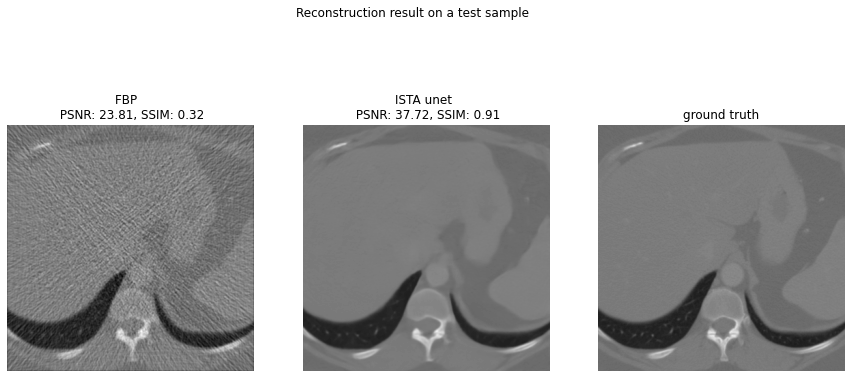

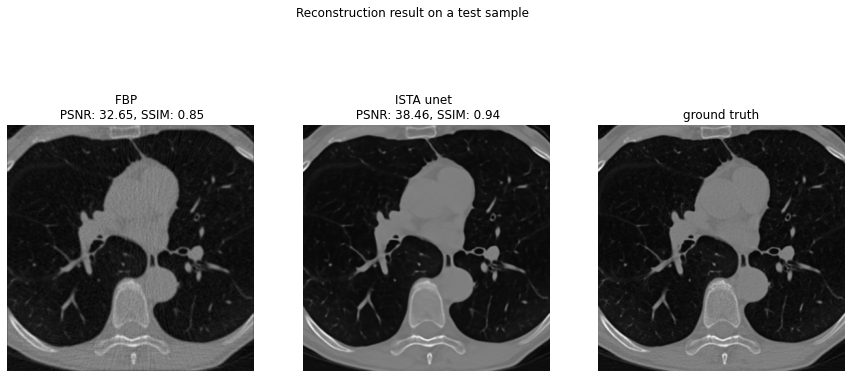

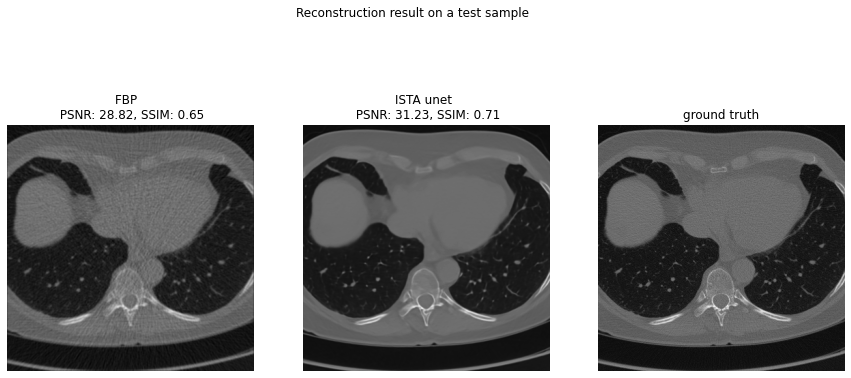

In [14]:
for sample_at in range(3):
    # sample_at = 1
    obs, gt = next(itertools.islice(loaders_bs1['test'], sample_at, None))

    recon = model(obs.to(device)).cpu().detach().numpy()
    # evaluate w/ psnr and ssim
    
    obs_psnr = PSNR(obs, gt)
    ista_unet_psnr = PSNR(recon, gt)

    obs_ssim = SSIM(obs[0,0].numpy(), gt[0,0].numpy())
    ista_unet_ssim = SSIM(recon[0,0], gt[0,0].numpy())

    _, ax = plot_images([obs.cpu()[0,0], recon[0,0], gt.cpu()[0,0]], fig_size=(15, 7), cbar = 'none')
    ax[0].set_title('FBP  \n PSNR: {:.2f}, SSIM: {:.2f}'.format(obs_psnr, obs_ssim) )
    ax[0].axis('off')
    ax[1].set_title('ISTA unet \n PSNR: {:.2f}, SSIM: {:.2f}'.format(ista_unet_psnr, ista_unet_ssim))
    ax[1].axis('off')
    ax[2].set_title('ground truth')
    ax[2].axis('off')

    ax[1].figure.suptitle('Reconstruction result on a test sample')